In [3]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import csv
import time

def write_to_file(stuff):
    csvFile = open(r'/Users/Sohail/Desktop/io-util.csv', 'a')
    csv_writer = csv.writer(csvFile)
    csv_writer.writerow( stuff  )
    csvFile.close()
def my_plotter(ax, data1, data2, param_dict, title=""):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    out = ax.plot(data1, data2, **param_dict)
    ax.figure.set_size_inches(20, 10)
    
    ax.set_title(title, fontsize=20)
    return out
def run_query(prom_query):
    """
    Get the response of a simple query from prometheus
    Arguments:
        prom_query: Prometheus query
    Returns:
        JSON response of the query results
    """
    parameters = {
        "query": prom_query
    }
    QUERY_URL = 'http://127.0.0.1:9090/api/v1/query'

    try:
        r = requests.get(QUERY_URL, params=parameters)
        if r.ok:
            return json.loads(r.content)
        else:
            return -1
    except Exception as e:
        print(e)
        return -1


def run_query_range(query, start_range, end_range, step):
    """
    Query prometheus data for a specific range

    Arguments:
        query: Prometheus query
        start_range: range start time in Epoch Timestamp
        end_range: range end time in Epoch Timestamp
        step: Resolution in seconds
    Returns:

    """
    QUERY_RANGE_URL = 'http://127.0.0.1:9090/api/v1/query_range'
    parameters = {
        "query": query,
        "start": start_range,
        "end": end_range,
        "step": step
    }

    result = []

    try:
        r = requests.get(QUERY_RANGE_URL, params=parameters)
        if r.ok:
            g = json.loads(r.text)
            for each in g['data']['result']:
                for x in each['values']:
                    j = each['metric']['instance'] + ',' + ','.join(str(y) for y in x)
                    result.append(tuple(j.split(',')))
        else:
            return -1
    except Exception as e:
        print(e)
        return -1

    return result

Queries = {
    "mem" : "100 * (1 - ((node_memory_MemFree{job='k8s-nodes'} + node_memory_Cached{job='k8s-nodes'} + node_memory_Buffers{job='k8s-nodes'}) / node_memory_MemTotal{job='k8s-nodes'}))",
    "cpu" : "100 - (avg by (instance) (irate(node_cpu{job='k8s-nodes',mode='idle'}[2m])) * 100)",
    "io_util" : "100 * (rate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000 or irate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000)"
}

Nodes = {
    "k8master" : "172.31.15.135:9100",
    "k8node" : "172.31.15.164:9100"
}

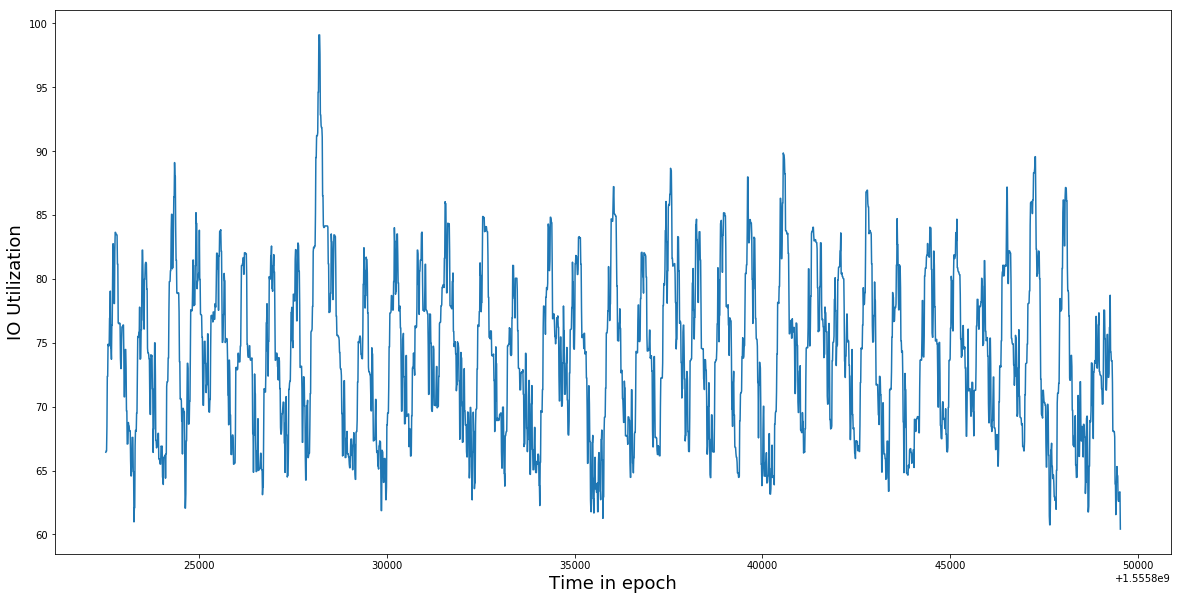

In [4]:
dataframe1 = pd.read_csv('/Users/Sohail/Desktop/io-util.csv')
x1 = dataframe1['TIME']
y1 = dataframe1['UTIL']

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [5]:
import warnings
warnings.filterwarnings('ignore')
aicVal = []
for i in range(1, 20):
    try:
        model_fit = ExponentialSmoothing(y1, seasonal_periods=i, trend='add', 
                                         seasonal='add').fit(use_boxcox=True)
        aicVal.append((i, model_fit.aic))
    except:
        continue

In [6]:
aicVal2 = aicVal;
aicVal2.sort(key=lambda x:x[1]);
aicVal2[0:10]

[(2, 3370.668421715528),
 (3, 3379.4677658316677),
 (4, 3522.2074080592683),
 (5, 3568.7642318737803),
 (6, 3657.4030353602143),
 (9, 3685.628855885935),
 (8, 3704.840531538582),
 (7, 3716.3013804117804),
 (10, 3768.504423227891),
 (27, 3803.5687780073163)]

In [7]:
split_percent = 0.8448
train_samples = int(len(x1) * split_percent)
forecast_time = len(x1) - train_samples
print(forecast_time)
print(train_samples)

420
2281


In [68]:
predictions = []
# for i in range(0, forecast_time, 6):
Y_Train = y1[0:0+train_samples]
model_fit = ExponentialSmoothing(Y_Train, seasonal_periods=50, seasonal='additive').fit(use_boxcox=True)
predictions.append(model_fit.forecast(420).values)

In [69]:
predictions = predictions[0].reshape(predictions[0].size, 1)

In [83]:
Pred = []
for i in range(5, forecast_time, 6):
    Pred.append(predictions[i])

In [84]:
X_Test = []
Y_Test = []
for i in range(6, forecast_time, 6):
    X_Test.append(x1[train_samples + i])
    Y_Test.append(y1[train_samples + i])

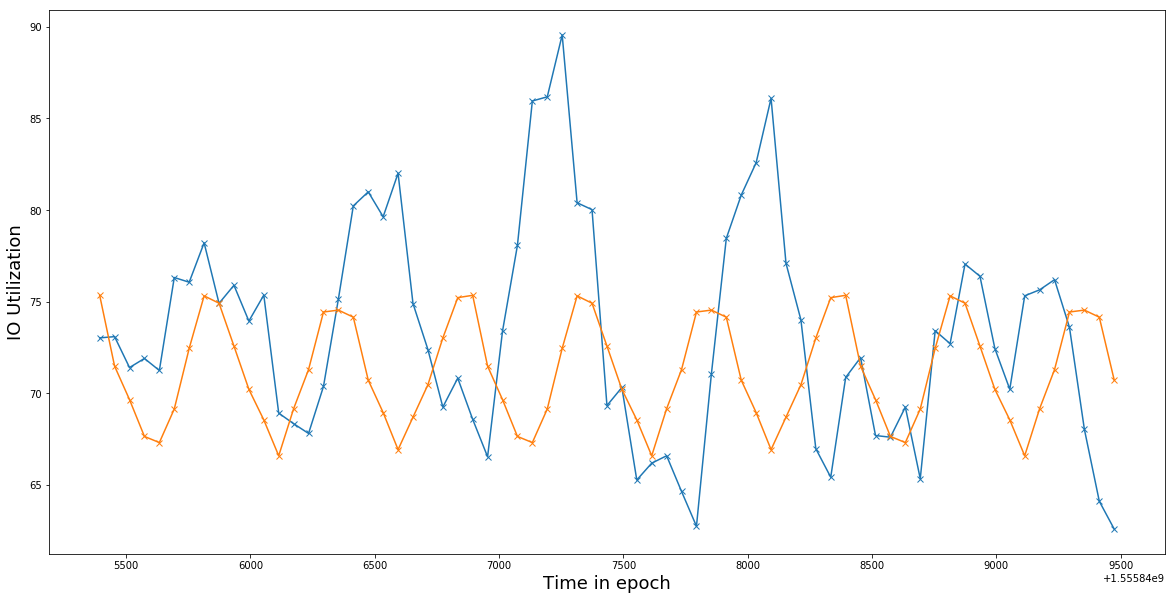

In [86]:
fig, ax = plt.subplots(1)

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)

my_plotter(ax, X_Test, Y_Test, {'marker': 'x'})
my_plotter(ax, X_Test, Pred[0:-1], {'marker': 'x'})

In [87]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [88]:
mean_absolute_percentage_error(Y_Test, Pred[0:-1])

7.247386012105536